# Question 1

Here, I explore how an individuals interest in politics, engagement in political activities and perceptions of democracy, authoritarianism, governance, and political ideologies predict their **participation at national-level elections**. To this end, I use data from the [World Values Survey Wave 7 (2017-2022)](https://www.worldvaluessurvey.org/WVSDocumentationWV7.jsp), which is comprised of responses from participants across 66 countries/territories. 

In [1]:
# Import modules
import pandas as pd
import shap
from catboost import CatBoostClassifier
from itertools import product
from matplotlib import pyplot as plt
from PyALE import ale
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.inspection import permutation_importance, PartialDependenceDisplay

/Users/samanthayom/Desktop/MACS 30135 Explainable & Interpretable Machine Learning/Graded Exercises/Graded Exercise 1/macs30135-graded-exercise-1/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Provide filenames
RAW_WVS_DATA = "data/wvs_wave_7.csv"
PREPROCESSED_WVS_DATA = "data/wvs_wave_7_preprocessed.csv"

## Data Preprocessing
The code for data preprocessing is provided but it cannot be run. This is because the raw data file has not been uploaded since it exceeds GitHub's file size limit. The preprocessed data has been uploaded and is loaded in the next section.

In [3]:
# Read raw data into dataframe
raw_df =  pd.read_csv(RAW_WVS_DATA, low_memory=False)

In [4]:
# Display general infromation about raw data
print(f"No. of rows: {raw_df.shape[0]}")
print(f"No. of columns: {raw_df.shape[1]}")
raw_df.head()

No. of rows: 97220
No. of columns: 613


,version,doi,A_WAVE,A_YEAR,A_STUDY,B_COUNTRY,B_COUNTRY_ALPHA,C_COW_NUM,C_COW_ALPHA,D_INTERVIEW,...,WVS_Polmistrust_PartyVoter,WVS_LR_MedianVoter,WVS_LibCon_MedianVoter,v2psbars,v2psorgs,v2psprbrch,v2psprlnks,v2psplats,v2xnp_client,v2xps_party
0,6-0-0 (2024-04-30),doi.org/10.14281/18241.24,7,2018,2,20,AND,232,AND,20070001,...,62.434211,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0
1,6-0-0 (2024-04-30),doi.org/10.14281/18241.24,7,2018,2,20,AND,232,AND,20070002,...,62.434211,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0
2,6-0-0 (2024-04-30),doi.org/10.14281/18241.24,7,2018,2,20,AND,232,AND,20070003,...,62.434211,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0
3,6-0-0 (2024-04-30),doi.org/10.14281/18241.24,7,2018,2,20,AND,232,AND,20070004,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,6-0-0 (2024-04-30),doi.org/10.14281/18241.24,7,2018,2,20,AND,232,AND,20070005,...,66.964286,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0


Now, that is a lot of data! It turns out we only need a subset of these columns that contain the responses to the questions related to: 1) Political Interest and Political Participation (Q199-220, 222, 224-234), and 2) Political Culture and Political Regimes (Q235-259). The mapping between column name and survey question can be found [here](https://www.worldvaluessurvey.org/WVSDocumentationWV7.jsp) (see WVS7 Codebook Variables Report). For the purpose of this exercise, I randomly sample 10,000 data instances (i.e., rows) to make up my dataset.

In [5]:
# Create list of columns to keep
columns_to_keep = []
columns_to_keep.extend([f"Q{n}" for n in range(199, 221)])
columns_to_keep.extend(["Q222"])
columns_to_keep.extend([f"Q{n}" for n in range(224, 235)])
columns_to_keep.extend([f"Q{n}" for n in range(235, 260)])
print(f"No. of questions: {len(columns_to_keep)}")

No. of questions: 59


In [6]:
df = raw_df[columns_to_keep]  # Keep only selected columns
df = df.dropna()  # Drop rows with missing values
df = df[(df >= 0).all(axis=1)]  # Drop rows with negative values (e.g., no answer)
df = df.sample(10000, random_state=8)  # Randomly sample 10,000 rows
df.reset_index(drop=True, inplace=True)  # Reset row indices

print(f"No. of rows: {df.shape[0]}")
print(f"No. of columns: {df.shape[1]}")
df.head()


No. of rows: 10000
No. of columns: 59


,Q199,Q200,Q201,Q202,Q203,Q204,Q205,Q206,Q207,Q208,...,Q250,Q251,Q252,Q253,Q254,Q255,Q256,Q257,Q258,Q259
0,2,2,5,2,1,2,1,1,5,2,...,10,8,6,1,1,2,2,2,3,3
1,4,3,5,1,1,1,5,1,1,2,...,10,5,2,3,1,1,1,1,1,1
2,2,2,2,1,4,1,4,1,1,1,...,10,7,7,2,1,1,1,1,2,2
3,4,3,5,1,1,5,5,1,1,5,...,9,9,2,1,1,3,3,2,4,4
4,2,2,4,3,2,1,3,5,2,2,...,10,7,8,2,1,1,1,1,1,1


In [7]:
df.to_csv(PREPROCESSED_WVS_DATA, index=False)  # Save preprocessed data to CSV

# Load Data
Here, we load the preprocessed data and split the data into a training and test set.

In [8]:
df = pd.read_csv(PREPROCESSED_WVS_DATA)  # Read preprocessed data into dataframe

Next, I obtain the features and outcome variable. The goal is to predict an individual's likelihood of participating in national-level elections, based on their response to the question: "When elections take place, do you vote always, usually or never?" (Q222). The possible responses are: 1) "Always", 2) "Usually", 3) "Never", and 4) "Not allowed to vote". I also split the data into a training and test set.

In [9]:
# Extract features and outcome variables
X = df.drop(columns=["Q222"])
y = df["Q222"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=8)

## Model Training, Evaluation & Selection
Given the outcome variable I've identified above, the task at hand is a classification one. For the purpose of this exercise, I have chosen to select an inherently interepretable supervised learning model, as well as an uninterpretable one for this task. Both tree-based models are ideal for capturing interactions between features, which I expect considering how some of the survey questions are likely to be closely related. I employ the following models:

1. Decision Tree
2. CatBoost

### Decision Tree

In [10]:
MAX_DEPTH_VALUES = [3, 5, 7, 9]  # List of max_depth values
CRITERION_VALUES = ["gini", "entropy"]  # List of criterion values

In [11]:
highest_accuracy = 0
best_max_depth, best_criterion = None, None

# Iterate through all combinations of max_depth and criterion to find model with highest accuracy
for (max_depth, criterion) in product(MAX_DEPTH_VALUES, CRITERION_VALUES):  
    dt = DecisionTreeClassifier(max_depth=max_depth, criterion=criterion, random_state=8)
    dt.fit(X_train, y_train)
    y_pred = dt.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"accuracy: {accuracy:.3f} | max_depth: {max_depth}, criterion: {criterion}")

    if accuracy > highest_accuracy: 
        highest_accuracy = accuracy
        best_max_depth, best_criterion = max_depth, criterion
    

print(f"\nBest accuracy: {highest_accuracy:.3f} (max_depth: {best_max_depth}, criterion: {best_criterion})")

accuracy: 0.634 | max_depth: 3, criterion: gini
accuracy: 0.632 | max_depth: 3, criterion: entropy
accuracy: 0.627 | max_depth: 5, criterion: gini
accuracy: 0.639 | max_depth: 5, criterion: entropy
accuracy: 0.625 | max_depth: 7, criterion: gini
accuracy: 0.633 | max_depth: 7, criterion: entropy
accuracy: 0.606 | max_depth: 9, criterion: gini
accuracy: 0.601 | max_depth: 9, criterion: entropy

Best accuracy: 0.639 (max_depth: 5, criterion: entropy)


In [12]:
# Obtain the decision tree model with the best accuracy
dt = DecisionTreeClassifier(max_depth=best_max_depth, criterion=best_criterion, random_state=8)
dt.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=5, random_state=8)

### CatBoost

In [13]:
MAX_DEPTH_VALUES = [6, 8, 10]  # List of max_depth values
LR_VALUES = [0.01, 0.1, 0.2]  # List of learning_rate values

In [14]:
highest_accuracy = 0
best_max_depth, best_lr = None, None

# Iterate through all combinations of max_depth and learning_rate to find model with highest accuracy
for max_depth, lr in product(MAX_DEPTH_VALUES, LR_VALUES):  
    cb = CatBoostClassifier(max_depth=max_depth, learning_rate=lr, random_state=8, verbose=False)
    cb.fit(X_train, y_train)
    y_pred = cb.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"accuracy: {accuracy:.3f} | max_depth: {max_depth}, learning rate: {lr}")

    if accuracy > highest_accuracy:
        highest_accuracy = accuracy
        best_max_depth, best_lr = max_depth, lr


print(f"\nBest accuracy: {highest_accuracy:.3f} (max_depth: {best_max_depth}, learning rate: {best_lr})")

accuracy: 0.653 | max_depth: 6, learning rate: 0.01
accuracy: 0.657 | max_depth: 6, learning rate: 0.1
accuracy: 0.651 | max_depth: 6, learning rate: 0.2
accuracy: 0.655 | max_depth: 8, learning rate: 0.01
accuracy: 0.654 | max_depth: 8, learning rate: 0.1
accuracy: 0.665 | max_depth: 8, learning rate: 0.2
accuracy: 0.659 | max_depth: 10, learning rate: 0.01
accuracy: 0.658 | max_depth: 10, learning rate: 0.1
accuracy: 0.662 | max_depth: 10, learning rate: 0.2

Best accuracy: 0.665 (max_depth: 8, learning rate: 0.2)


In [15]:
# Obtain the CatBoost model with the best accuracy
cb = CatBoostClassifier(max_depth=best_max_depth, learning_rate=best_lr, random_state=8, verbose=False)
cb.fit(X_train, y_train)

## Model Interpretation
Now that we've selected our decision tree and CatBoost models, apply the following techniques to intepret the relationships between the features and predictions.

In [16]:
feature_names = X.columns

### Permutation Feature Importance

In [17]:
# Calculate permutation importance 
dt_perm_importance = permutation_importance(dt, X_test, y_test, n_repeats=10, random_state=8, scoring="accuracy")
cb_perm_importance = permutation_importance(cb, X_test, y_test, n_repeats=10, random_state=8, scoring="accuracy")

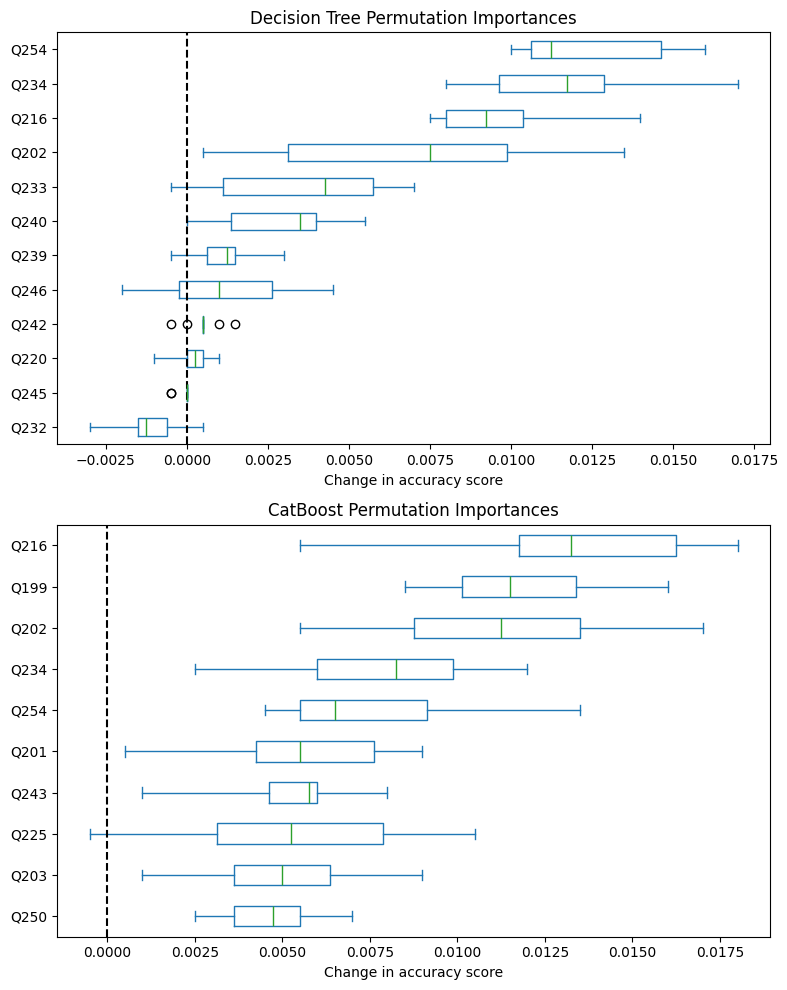

In [18]:
# Plot the permutation importance
dt_sorted_idx = dt_perm_importance.importances_mean.argsort()
dt_perm_importance_df = pd.DataFrame(
    dt_perm_importance.importances[dt_sorted_idx].T,
    columns=feature_names[dt_sorted_idx],
)
dt_perm_importance_df = dt_perm_importance_df.loc[:, (dt_perm_importance_df != 0).any(axis=0)]  # Drop features with zero importance


cb_sorted_idx = cb_perm_importance.importances_mean.argsort()[-10:]  # Select the top 10 most important features
cb_perm_importance_df = pd.DataFrame(
    cb_perm_importance.importances[cb_sorted_idx].T,
    columns=feature_names[cb_sorted_idx],
)


fig, ax = plt.subplots(2, 1, figsize=(8, 10))
ax[0] = dt_perm_importance_df.plot.box(vert=False, whis=10, ax=ax[0])
ax[0].set_title("Decision Tree Permutation Importances")
ax[0].axvline(x=0, color="k", linestyle="--")
ax[0].set_xlabel("Change in accuracy score")

ax[1] = cb_perm_importance_df.plot.box(vert=False, whis=10, ax=ax[1])
ax[1].set_title("CatBoost Permutation Importances")
ax[1].axvline(x=0, color="k", linestyle="--")
ax[1].set_xlabel("Change in accuracy score")

ax[1].figure.tight_layout()
plt.show()

In [19]:
common_features = set(dt_perm_importance_df.columns) & set(cb_perm_importance_df.columns)
print(f"The top features identied by both models are: {", ". join(common_features)}")

The top features identied by both models are: Q202, Q254, Q216, Q234


Sources:
* https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance.html#sphx-glr-auto-examples-inspection-plot-permutation-importance-py

### SHAP Summary Plot

In [20]:
# Get SHAP values for decision tree model
dt_explainer = shap.Explainer(dt.predict, X_test)
dt_shap_values = dt_explainer(X_test)

PermutationExplainer explainer: 2001it [00:46, 38.73it/s]                          


In [21]:
# Get SHAP values for CatBoost model
cb_explainer = shap.Explainer(cb.predict, X_test)
cb_shap_values = cb_explainer(X_test)


PermutationExplainer explainer: 2001it [02:38, 11.93it/s]                          


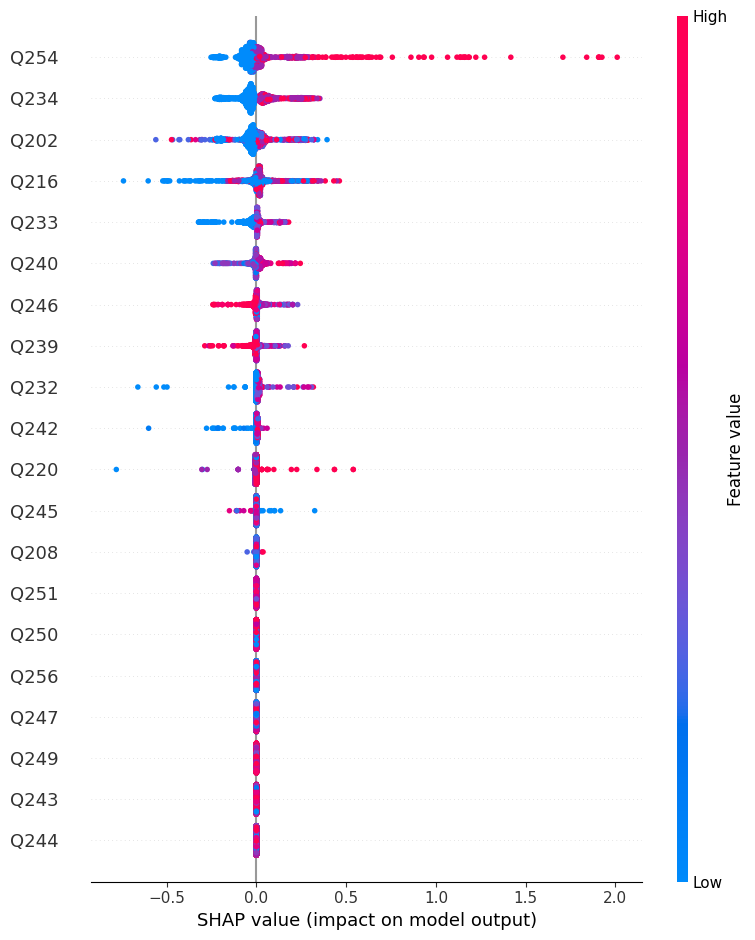

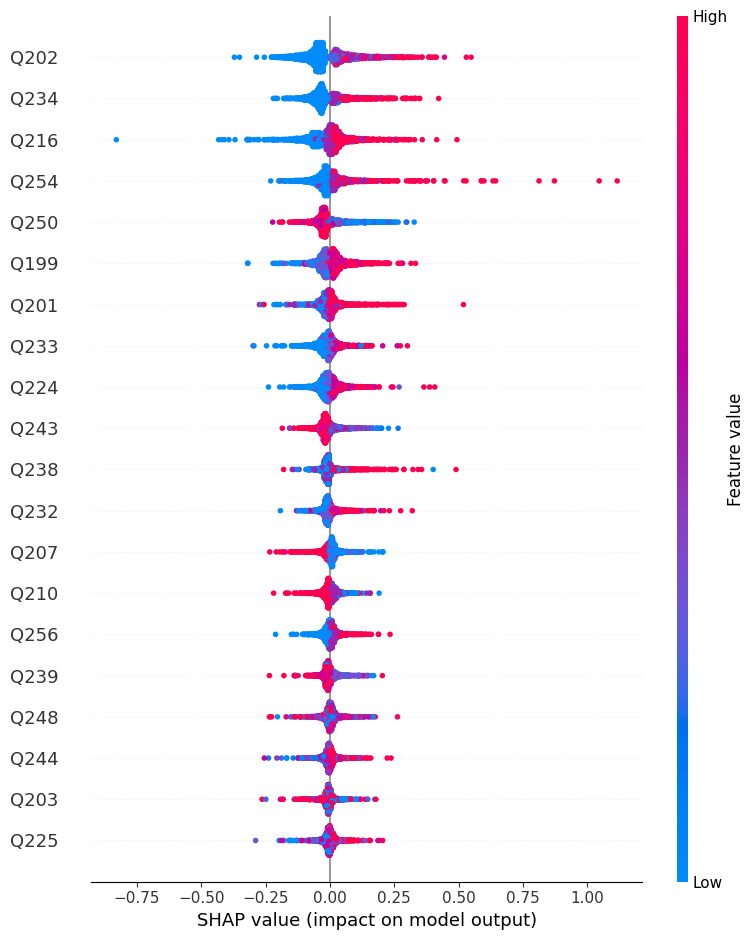

In [22]:
shap.summary_plot(dt_shap_values)
shap.summary_plot(cb_shap_values)

### Partial Dependence Plot

We perform a plot for the top feature of each model, based on the feature importances we've identified above.

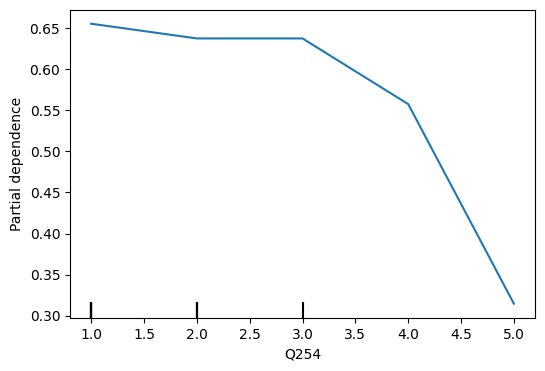

In [23]:
fig, ax = plt.subplots(figsize=(6, 4))
dt_pdp = PartialDependenceDisplay.from_estimator(dt, X_test, ["Q254"], target=1, ax=ax)  # Set target to 1 (i.e., "Always vote in national elections")

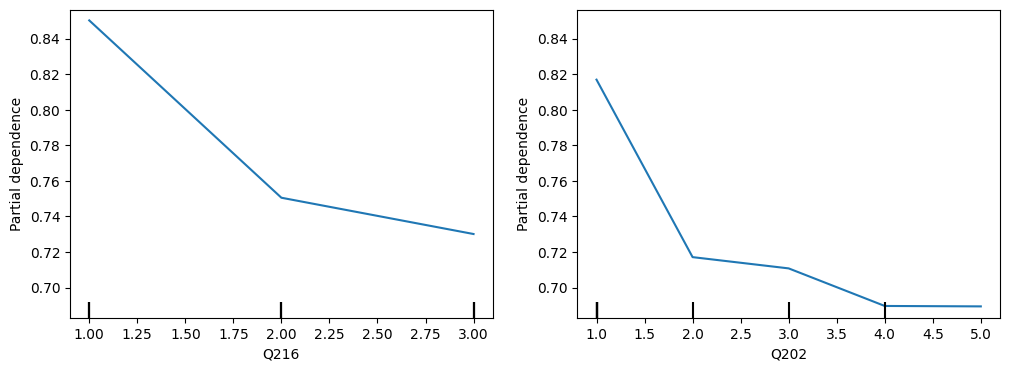

In [24]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
cb_pdp = PartialDependenceDisplay.from_estimator(cb, X_test, ["Q216", "Q202"], target=1, ax=ax)  # Set target to 1

Sources:
* https://scikit-learn.org/stable/auto_examples/miscellaneous/plot_partial_dependence_visualization_api.html

### Accumulated Local Effects

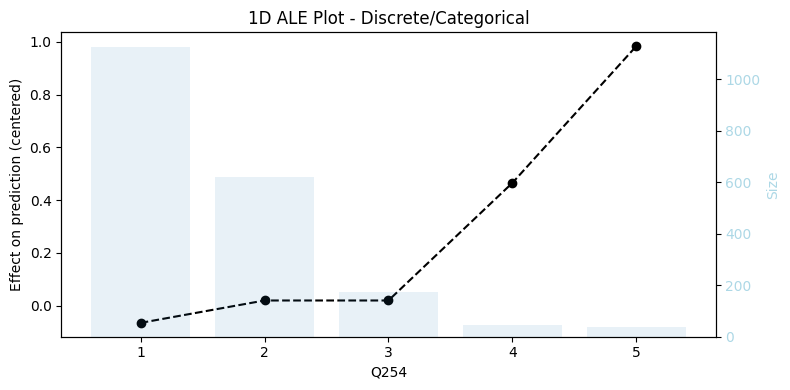

In [25]:
dt_ale_effect = ale(X=X_test, model=dt, feature=["Q254"], feature_type="discrete", include_CI=False)

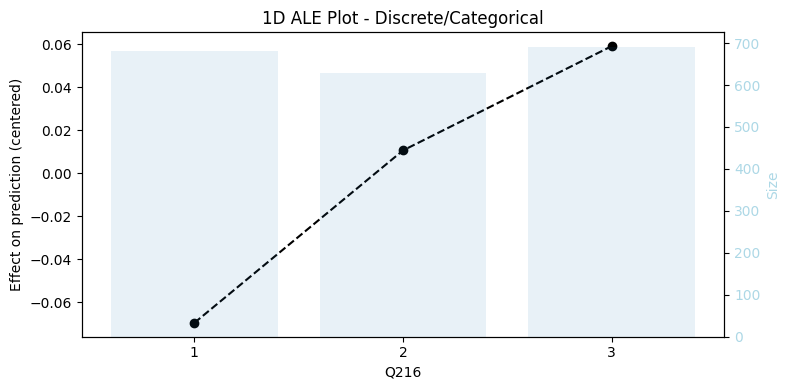

In [26]:
cb_ale_effect_q216 = ale(X=X_test, model=cb, feature=["Q216"], feature_type="discrete", include_CI=False)

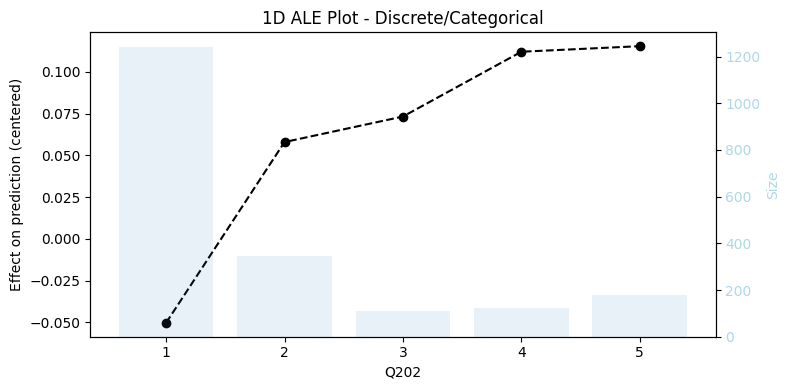

In [27]:
cb_ale_effect_q202 = ale(X=X_test, model=cb, feature=["Q202"], feature_type="discrete", include_CI=False)

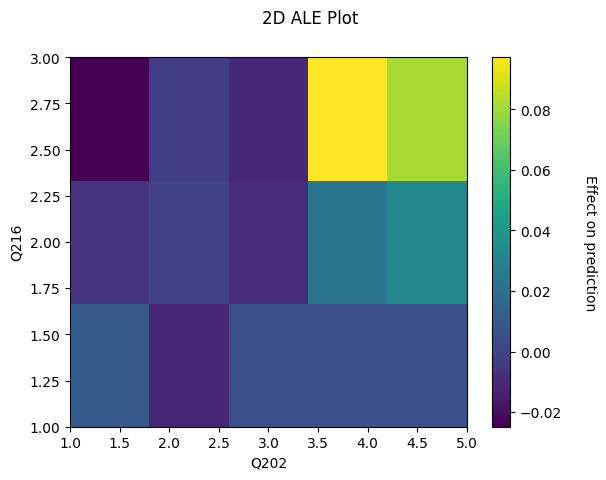

In [28]:
cb_ale_effect_2d = ale(X=X_test, model=cb, feature=["Q216", "Q202"], feature_type="discrete", include_CI=False)

Sources:
* https://htmlpreview.github.io/?https://github.com/DanaJomar/PyALE/blob/master/examples/Examples.html